<a href="https://colab.research.google.com/github/hiu04/Data-Science/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the data with Huggingface's DatasetDict

In [126]:
# Read the COCO formatted annotations to a dict, the json file download from
# Lable studio
import json
with open('/content/data/result.json') as f:
  cocodata = json.load(f)

In [127]:
# Convert the COCO formatted dict to a format readable by dataset.load_dataset()

# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
  # Remove the image directory from the file name
  image['file_name'] = image['file_name'].split('/')[-1]
  image['image_id'] = image['id']
  # Extend the image dict with bounding boxes and class labels
  image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
  # Iterate through the annotations (bounding boxes and labels)
  for annot in cocodata['annotations']:
    # Check if the annotation matches the image
    if annot['image_id'] == image['id']:
      # Add the annotation
      image['objects']['bbox'].append(annot['bbox'])
      image['objects']['category'].append(annot['category_id'])
      image['objects']['area'].append(annot['area'])
      image['objects']['id'].append(annot['id'])
  # Append the image dict with annotations to the list
  huggingdata.append(image)

In [ ]:
# Write the Huggingface formatted annotations to a json file
with open("/content/data/images/metadata.jsonl", 'w') as f:
  for item in huggingdata:
    f.write(json.dumps(item) + "\n")

- Follow Create an image dataset and the section Create an image dataset: object detection to organize the images and metadata.jsonl into the correct folder structure.

Download export folder from label studio.


In [ ]:
# Upload the images download from Label Studio
!unzip /content/images.zip -d /content/data/images

In [ ]:
!pip install datasets

In [129]:
#  Read the data into a DatasetDict.

from datasets import load_dataset
dataset = load_dataset('imagefolder', data_dir="/content/data/images")


In [ ]:
dataset

Dataset({
    features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
    num_rows: 11
})

In [130]:
train_dataset = dataset['train']

# Split the train dataset
dataset1 = train_dataset.train_test_split(test_size=0.2)
print(dataset1)


DatasetDict({
    train: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 8
    })
    test: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 3
    })
})


In [132]:
from datasets.arrow_dataset import dataset_to_tf
import numpy as np
import os
from PIL import Image, ImageDraw

image_data = dataset1["train"][0]
annotations = image_data["objects"]

image = image_data["image"]

draw = ImageDraw.Draw(image)


# Initialize an empty set to store unique category IDs
category_ids = set()

# Iterate through the dataset to collect unique category IDs
for item in dataset1["train"]:
    for obj in item["objects"]["category"]:  # 'category' is a sequence of integers
        category_ids.add(obj)

# Now category_ids is a set of all unique category IDs
print(category_ids)



{0, 1, 2, 3, 4, 5, 6, 7}


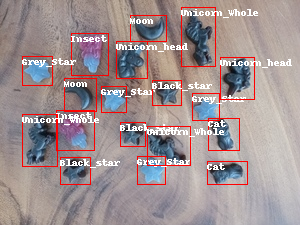

In [133]:
# You can then create your id2label and label2id mappings
id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}


for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

## Preprocess the data

In [ ]:
!pip install transformers

In [134]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [135]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(500, 500),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [136]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [137]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [138]:
dataset1["train"] = dataset1["train"].with_transform(transform_aug_ann)

In [139]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training the DETR model

In [ ]:
!pip install timm
!pip install transformers[torch]

In [140]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [142]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content",
    per_device_train_batch_size=8,
    num_train_epochs=500,
    fp16=False,
    save_steps=200,
    logging_steps=10,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [144]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset1["train"],
    tokenizer=image_processor,
)

trainer.train()

Step,Training Loss
10,3.376700
20,2.838300
30,2.682900
40,2.546100
50,2.440200
60,2.353700
70,2.283900
80,2.221200
90,2.175600
100,2.127500


TrainOutput(global_step=500, training_loss=1.631052713394165, metrics={'train_runtime': 774.5444, 'train_samples_per_second': 5.164, 'train_steps_per_second': 0.646, 'total_flos': 1.91129872896e+18, 'train_loss': 1.631052713394165, 'epoch': 500.0})

In [145]:
trainer.save_model('/content/candy_detector')

## Evaluate

In [174]:
import os
import json

id2label =  {
 'Moon': 1,
 'Insect': 2,
 'Black_star': 3,
 'Grey_star': 4,
 'Unicorn_whole': 5,
 'Unicorn_head': 6,
 'Owl': 7,
 'Cat': 8
 }

def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

def save_candy_annotations(cppe5):
    output_json = {}
    path_output_candy = f"{os.getcwd()}/candy_data/"

    if not os.path.exists(path_output_candy):
        os.makedirs(path_output_candy)

    path_anno = os.path.join(path_output_candy, "candy_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_candy, f"{img_id}.png")
        im.save(path_img)

    return path_output_candy, path_anno


In [182]:
import torchvision
from transformers import AutoImageProcessor

class CandyCocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]
        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained(checkpoint)


path_output_candy, path_anno = save_candy_annotations(dataset1["test"])
test_ds_coco_format = CandyCocoDetection(path_output_candy, im_processor, path_anno)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
!pip install evaluate

In [184]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained(checkpoint)
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [185]:
with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

100%|██████████| 1/1 [00:35<00:00, 35.89s/it]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95

## Detection

In [202]:
# dataset1['test'][0]
image = Image.open("/content/data/images/ccb76443-cd_07.jpg")

In [203]:
image_processor = AutoImageProcessor.from_pretrained("candy_detector")
model = AutoModelForObjectDetection.from_pretrained("candy_detector")

In [204]:
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.25,
                                                            target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Grey_Star with confidence 0.301 at location [138.14, 159.57, 166.88, 185.04]
Detected Black_star with confidence 0.318 at location [154.16, 82.38, 179.26, 106.45]
Detected Unicorn_Whole with confidence 0.319 at location [22.95, 110.27, 56.74, 168.19]
Detected Moon with confidence 0.259 at location [131.06, 6.13, 167.21, 41.56]
Detected Black_star with confidence 0.269 at location [152.56, 81.6, 178.61, 107.05]
Detected Unicorn_Whole with confidence 0.302 at location [140.21, 128.28, 183.5, 165.31]
Detected Unicorn_Whole with confidence 0.285 at location [183.2, 7.14, 219.51, 66.78]


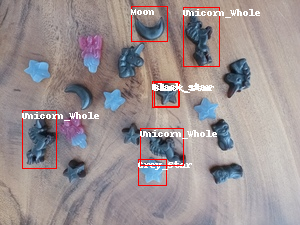

In [205]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

## Final

In [192]:
def candy_counter(image_path, model_path):
  image = Image.open(image_path)
  final_dic = {'Moon': 0,'Insect': 0,'Black_star': 0,'Grey_star': 0,
               'Unicorn_whole': 0,'Unicorn_head': 0,'Owl': 0,'Cat': 0}
  image_processor = AutoImageProcessor.from_pretrained("candy_detector")
  model = AutoModelForObjectDetection.from_pretrained("candy_detector")

  with torch.no_grad():
      inputs = image_processor(images=image, return_tensors="pt")
      outputs = model(**inputs)
      target_sizes = torch.tensor([image.size[::-1]])
      results = image_processor.post_process_object_detection(outputs, threshold=0.25, target_sizes=target_sizes)[0]

  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      label_name = model.config.id2label[label.item()]
      if label_name not in final_dic:
        final_dic[label_name] = 1
      else:
        final_dic[label_name] = final_dic[label_name] + 1

  return final_dic


In [193]:
candy_counter(image_path='/content/data/images/ccb76443-cd_07.jpg',
              model_path='/content/candy_detector')

{'Moon': 1,
 'Insect': 0,
 'Black_star': 2,
 'Grey_star': 0,
 'Unicorn_whole': 0,
 'Unicorn_head': 0,
 'Owl': 0,
 'Cat': 0,
 'Grey_Star': 1,
 'Unicorn_Whole': 3}

In [ ]:
from google.colab import files
files.download('/content/candy_detector')

In [207]:
from google.colab import files
import shutil

# Create a zip archive of the candy_detector folder
shutil.make_archive("candy_detector", 'zip', "candy_detector")

# Download the created zip file
files.download("candy_detector.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>